In [1]:
import torch
import networkx as nx
from torch_geometric.nn import SAGEConv, to_hetero
from torch import optim
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
from torch_geometric.nn import HeteroConv, GCNConv, SAGEConv, GATConv, Linear, HGTConv, RGCNConv
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from torch_geometric.data import HeteroData, Data
from evaluation import *
from NN_Models import *
import json
import numpy as np
import pandas as pd
from preprocessing import *
from torch_geometric.nn import GATConv, Linear, to_hetero

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f = open('../../data/train.json', 'rb')
train_raw = json.load(f)

f = open('../../data/test.json', 'rb')
test_raw = json.load(f)

In [3]:
keywords_ = {}
for key in range(5000):
    keywords_[key] = 0

for instance in tqdm(train_data, total=len(train_data)):
    for word in instance['abstract']:
        keywords_[word] += 1
    for word in instance['title']:
        keywords_[word] += 1

for instance in tqdm(test_data, total=len(test_data)):
    for word in instance['abstract']:
        keywords_[word] += 1
    for word in instance['title']:
        keywords_[word] += 1

100%|██████████| 800/800 [00:00<00:00, 27418.90it/s]


In [4]:
num_words = 4999
num_coauthor = 21245-100+1
num_class = 100
num_venue = 465
num_year = 20

In [5]:
print("remain data length = ", len(train_raw))

print("train keys  : ", train_data[0].keys())
print("test keys   : ", test_data[0].keys())

remain data length =  25793
train keys  :  dict_keys(['authors', 'year', 'abstract', 'venue', 'title'])
test keys   :  dict_keys(['identifier', 'coauthors', 'year', 'abstract', 'venue', 'title'])


### Create Heterogenous Dataset

In [6]:
train_df = pd.DataFrame(columns=['year', 'venue', 'coauthor', 'label', 'text', 'train_mask', 'val_mask', 'test_mask'])

index = 0
def make_str(x):
    try:
        x[0] += ' '
        return x
    except:
        res = ''
        for i in x:
            res += str(i) + ' '
        return res[:-1]

for i in tqdm(range(len(train_raw)), desc="creating hetero data (train)"):
    coauthor = [0 for _ in range(num_coauthor)]
    pauthor = [0 for _ in range(num_class)]
    for j in train_raw[i]['authors']:
        if j < 100:
            pauthor[j] += 1
            
        else:
            coauthor[j-num_class] += 1


    train_df.loc[index, 'year'] = train_raw[i]['year']
    if train_raw[i]['venue']:
        train_df.loc[index, 'venue'] = train_raw[i]['venue']
    else:
        train_df.loc[index, 'venue'] = -1
    
    
    train_df.loc[index, 'coauthor'] = coauthor
    train_df.loc[index, 'label'] = pauthor
    text = []
    for t in train_raw[i]['abstract'] + train_raw[i]['title']:
        text.append(t)
    train_df.loc[index, 'text'] = text
    
    index += 1


for i in tqdm(range(len(test_raw)), desc="creating hetero data (kaggle)"):
    
    train_df.loc[index, 'year'] = test_raw[i]['year']
    if test_raw[i]['venue']:
        train_df.loc[index, 'venue'] = test_raw[i]['venue']
    else:
        train_df.loc[index, 'venue'] = -1
    
    coauthor = [0 for _ in range(num_coauthor)]
    pauthor = [0 for _ in range(num_class)]
    # pauthor = 100
    for j in train_raw[i]['authors']:
        coauthor[j-num_class] += 1

    train_df.loc[index, 'coauthor'] = coauthor
    train_df.loc[index, 'label'] = pauthor
    text = []
    for t in test_raw[i]['abstract'] + test_raw[i]['title']:
        # if t in keywords.keys():
        #     text.append(keywords[t])
        text.append(t)
    train_df.loc[index, 'text'] = text

    index += 1

train_df['id'] = train_df.index

creating hetero data (kaggle): 100%|██████████| 800/800 [00:05<00:00, 142.91it/s]


In [7]:
train_len = int(0.8 * (len(train_df) - 800))
val_len = int(0.2 * (len(train_df) - 800))
print("train length      : ", train_len)
print("validation length : ", val_len)

train_df.train_mask = train_df.id.apply(lambda x: x<train_len)
train_df.val_mask = train_df.id.apply(lambda x: x >= train_len and x < (train_len+val_len))
train_df.test_mask = train_df.id.apply(lambda x: x >= (len(train_df)-800))

train length      :  20634
validation length :  5158


In [8]:
train_df.head(2)

,year,venue,coauthor,label,text,train_mask,val_mask,test_mask,id
0,9,20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...",True,False,False,0
1,15,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...",True,False,False,1


In [9]:
write_edges = []
venue_publish_edges = []
year_publish_edges = []

# author write paper
for j in tqdm(train_df.index, total=len(train_df.index), desc='author write paper'):
    coauthror = train_df.loc[j, 'coauthor']
    for i in range(len(coauthor)):
        if coauthor[i] == 1:
            write_edges.append([i, j])


# paper published at venue
for i in tqdm(train_df.index, total=len(train_df.index), desc='paper published at venue'):
    venue = train_df.loc[i, 'venue']
    if venue != -1:
        venue_publish_edges.append([i, venue])


# paper published in year
for i in tqdm(train_df.index, total=len(train_df.index), desc='paper published in year'):
    year = train_df.loc[i, 'year']
    year_publish_edges.append([i, year])
    

paper published in year: 100%|██████████| 26593/26593 [00:00<00:00, 78699.60it/s]


In [10]:
# # coauthor write at venue
coauthor_venue_edges = []
coauthor_venue = {}
for i in tqdm(train_df.index, total=len(train_df.index), desc='coauthor write at venue'):
    venue = train_df.loc[i, 'venue']
    if venue != -1:
        coau = train_df.loc[i, 'coauthor']
        for au in range(len(coau)):
            if coau[au] == 1:
                coauthor_venue[f'{venue},{au}'] = 1

for key in tqdm(coauthor_venue.keys(), total=len(coauthor_venue.keys())):
    val = key.split(',')
    coauthor_venue_edges.append([int(val[1]), int(val[0])])

100%|██████████| 44241/44241 [00:00<00:00, 609473.18it/s]


In [11]:
############# path_data

data = HeteroData()

data['coauthor', 'write', 'paper'].edge_index = torch.LongTensor(write_edges).T
data['paper', 'published_venue', 'venue'].edge_index = torch.LongTensor(venue_publish_edges).T

data.num_nodes_dict = {'paper': len(train_df), 'coauthor': num_coauthor, 'venue': num_venue}

data = T.ToUndirected()(data)

data

HeteroData(
  num_nodes_dict={
    paper=26593,
    coauthor=21146,
    venue=465
  },
  (coauthor, write, paper)={ edge_index=[2, 132965] },
  (paper, published_venue, venue)={ edge_index=[2, 20955] },
  (paper, rev_write, coauthor)={ edge_index=[2, 132965] },
  (venue, rev_published_venue, paper)={ edge_index=[2, 20955] }
)

In [22]:
from torch_geometric.nn import MetaPath2Vec

# metapat
metapath = [
    ('coauthor', 'write', 'paper'),
    ('paper', 'published_venue', 'venue'),
    ('venue', 'rev_published_venue', 'paper'),
    ('paper', 'rev_write', 'coauthor'),
]

metaModel = MetaPath2Vec(
    data.edge_index_dict,
    embedding_dim=128,
    metapath=metapath,
    walk_length=5,
    context_size=3,
    walks_per_node=1,
    num_negative_samples=1,
    sparse=True
)

In [23]:
loader = metaModel.loader(batch_size=128, shuffle=True, num_workers=3)
optimizer = torch.optim.SparseAdam(list(metaModel.parameters()), lr=0.01)

In [25]:
def train(epochs, log_steps=500, eval_steps=1000):
    metaModel.train()

    total_loss = 0

    for i, (pos_rw, neg_rw) in enumerate(loader):
        optimizer.zero_grad()
        loss = metaModel.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        # print(loss)
        total_loss += loss.item()

    return total_loss/len(loader)

In [26]:
loss_list = []
for epoch in tqdm(range(200)):
    loss = train(epoch)
    loss_list.append(loss)

100%|██████████| 200/200 [17:19<00:00,  5.20s/it]


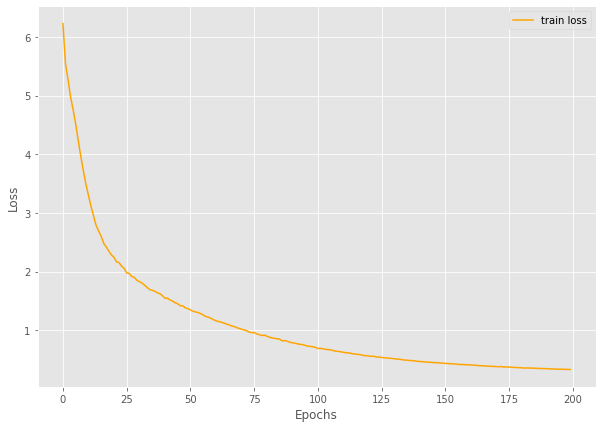

In [29]:
n = Model()
n.train_loss = loss_list
n.plot_loss()

In [31]:
def test(train_ratio=0.1):
    metaModel.eval()

    z = metaModel('paper', batch=data.y_index_dict['paper'])
    y = data.y_dict['paper']

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[:int(z.size(0) * train_ratio)]
    return metaModel.test(z[train_perm], y[train_perm], z[test_perm],
                            y[test_perm], max_iter=150)

test()

0.9406494960806271

In [ ]:
metaModel('paper').shape
metaModel('coauthor').shape

# GNN

In [68]:
# data['paper'].x = torch.tensor(train_df.doc2vec)
data['paper'].x = metaModel('paper')
data['paper'].train_mask = torch.tensor(train_df.train_mask)
data['paper'].test_mask = torch.tensor(train_df.test_mask)
data['paper'].val_mask = torch.tensor(train_df.val_mask)
data['paper'].y = torch.tensor(train_df.label, dtype=torch.float)

data['coauthor'].x = metaModel('coauthor')
data['venue'].x = metaModel('venue')
# data['keywords'].x = metaModel('keywords')

# data['year'].x = metaModel('year')

In [69]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

for edge in data.edge_index_dict:
    edge_idx = data.edge_index_dict[edge]
    edge_attr = []

    print(edge)
    for i in tqdm(range(edge_idx.shape[1])):
        input1 = data[edge[0]].x[edge_idx[0][i]]
        input2 = data[edge[2]].x[edge_idx[1][i]]
        
        edge_attr.append([cos(input1, input2).item()])

    edge_attr = torch.tensor(edge_attr)
    data[edge].edge_attr = edge_attr

('coauthor', 'write', 'paper')


100%|██████████| 50770/50770 [00:04<00:00, 11034.18it/s]


('paper', 'published_venue', 'venue')


100%|██████████| 7777/7777 [00:00<00:00, 12733.38it/s]


('paper', 'rev_write', 'coauthor')


100%|██████████| 50770/50770 [00:04<00:00, 11366.79it/s]


('venue', 'rev_published_venue', 'paper')


100%|██████████| 7777/7777 [00:00<00:00, 12330.27it/s]


In [70]:
data

HeteroData(
  paper={
    x=[10154, 128],
    train_mask=[10154],
    test_mask=[10154],
    val_mask=[10154],
    y=[10154, 100]
  },
  coauthor={ x=[17481, 128] },
  venue={ x=[465, 128] },
  (coauthor, write, paper)={
    edge_index=[2, 50770],
    edge_attr=[50770, 1]
  },
  (paper, published_venue, venue)={
    edge_index=[2, 7777],
    edge_attr=[7777, 1]
  },
  (paper, rev_write, coauthor)={
    edge_index=[2, 50770],
    edge_attr=[50770, 1]
  },
  (venue, rev_published_venue, paper)={
    edge_index=[2, 7777],
    edge_attr=[7777, 1]
  }
)

### Heterogenous GNN Models

In [71]:
for i in data.edge_index_dict:
    print(i)

('coauthor', 'write', 'paper')
('paper', 'published_venue', 'venue')
('paper', 'rev_write', 'coauthor')
('venue', 'rev_published_venue', 'paper')


In [96]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_attr):
        x = self.conv1(x, edge_attr).relu()
        x = self.conv2(x, edge_attr)
        return torch.sigmoid(x)


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.lin1 = Linear(-1, hidden_channels)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)
        self.lin2 = Linear(-1, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr) + self.lin1(x)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr) + self.lin2(x)
        x = x.relu()
        return torch.sigmoid(x)
        # return x



class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('coauthor', 'write', 'paper'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
                ('paper', 'rev_write', 'coauthor'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
                ('coauthor', 'write_at', 'venue'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
                ('venue', 'rev_write_at', 'coauthor'): GATConv((-1, -1), hidden_channels, add_self_loops=False),

                ('keywords', 'appear_in', 'paper'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
                ('paper', 'rev_appear_in', 'keywords'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
                ('coauthor', 'contain', 'keywords'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
                ('keywords', 'rev_contain', 'coauthor'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
            }, aggr='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict, edge_attr):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict, edge_attr)
            x_dict = {key: x.relu() for key, x in x_dict.items()}

        return torch.sigmoid(self.lin(x_dict['paper']))
        # return self.lin(x_dict['paper'])


class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in data.node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data.metadata(),
                           num_heads, group='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return self.lin(x_dict['paper'])
        # return torch.sigmoid(self.lin(x_dict['paper']))

In [97]:
# model = GNN(hidden_channels=64, out_channels=num_class)
# model = to_hetero(model, data.metadata(), aggr='sum')

# model = GAT(hidden_channels=64, out_channels=num_class)
# model = to_hetero(model, data.metadata(), aggr='sum')

# model = HeteroGNN(hidden_channels=64, out_channels=num_class, num_layers=2)

model = HGT(hidden_channels=64, out_channels=num_class, num_heads=2, num_layers=2)

In [98]:
with torch.no_grad():  # Initialize lazy modules.
    # out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
    out = model(data.x_dict, data.edge_index_dict)

In [99]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(epochs=100):
    loss_list = []
    mask = data['paper'].train_mask
    print("train size : ", data['paper'].y[mask].shape[0])
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        # out = model(data.x_dict, data.edge_index_dict, data.edge_attr_dict)
        out = model(data.x_dict, data.edge_index_dict)
        # print(out['paper'][mask].dtype)
        # print(data['paper'].y[mask].dtype)

        # loss = nn.BCELoss()(out[mask], data['paper'].y[mask])
        loss = nn.BCEWithLogitsLoss()(out[mask], data['paper'].y[mask])
        # loss = nn.BCELoss()(out['paper'][mask], data['paper'].y[mask])
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
    
    return loss_list

In [101]:
loss_list = train(100)

train size :  7483


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


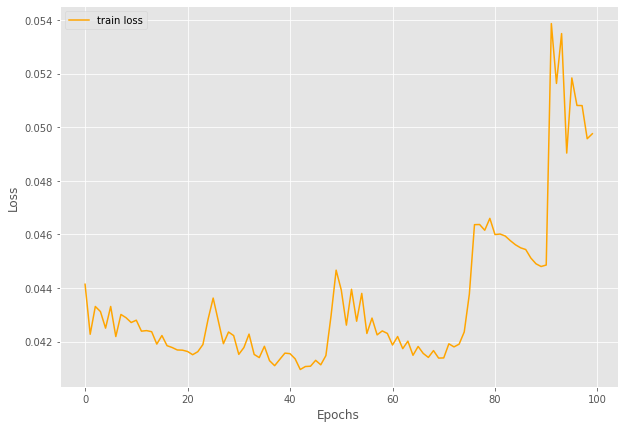

In [102]:
n = Model()
n.train_loss = loss_list
n.plot_loss()

In [103]:
loss_list[-1]

0.04975322261452675

0.05317302048206329

In [104]:
# logits = torch.sigmoid(model(data.x_dict, data.edge_index_dict))
logits = model(data.x_dict, data.edge_index_dict)

In [107]:
# logits.shape
logits.max()

tensor(0.0618, grad_fn=<MaxBackward1>)

In [106]:
a = torch.tensor(-4)
torch.sigmoid(a)

tensor(0.0180)

In [85]:
sum(data['paper'].test_mask)

tensor(800)

In [86]:
# val_mask = data['paper'].train_mask
val_mask = data['paper'].val_mask

test_list = to_list(data['paper'].y[val_mask])

# test_list = data['paper'].y[val_mask].tolist()
# test_list = []

print(len(test_list))

1870


In [87]:
# type(test_list[0])
# test_list
# val_logits

In [90]:
# val_logits = logits['paper'][val_mask]
val_logits = logits[val_mask]

def find_threshold(thresholds):
    max_thred = 0
    max_f1 = 0
    max_pred_list = []
    for threshold in tqdm(thresholds, total=len(thresholds)):
        pred_list = []
        
        for i in range(len(val_logits)):
            pred_au = ""
            for j in range(100):
                if val_logits[i, j] > threshold:
                    pred_au += str(j) + " "
            if pred_au:
                pred_list.append(pred_au[:-1])
            else:
                pred_list.append('-1')

            # pred_list.append(val_logits[i].index(max(val_logits[i])))

        f1 = f1_score(test_list, pred_list, average='weighted')

        if f1 >= max_f1:
            max_f1 = f1
            max_thred = threshold
            max_pred_list = pred_list

    return threshold, max_pred_list

In [91]:
# thresholds = np.linspace(0, 0.5, 100)
thresholds = [0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 0.9]
# thresholds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
threshold, pred_list = find_threshold(thresholds)
print(threshold)
print_scores(test_list, pred_list)

100%|██████████| 8/8 [00:35<00:00,  4.43s/it]

0.9
=========================Evaluation results=========================
The accuracy score of prediction is : 0.2
The recall   score of prediction is : 0.2
The f1       score of prediction is : 0.06666666666666668


### Kaggle

In [92]:
# sum(test_mask)
train_df.test_mask.value_counts()

False    9354
True      800
Name: test_mask, dtype: int64

In [94]:
threshold = 0.1

test_mask = data['paper'].test_mask

# test_logits = logits['paper'][test_mask]
test_logits = logits[test_mask]

kaggle_predict = []

for i in tqdm(range(len(test_logits))):
    pred_au = ""
    for j in range(100):
        if test_logits[i, j] >= threshold:
            if j == 100:
                
                break
            pred_au += str(j) + " "

    if pred_au:
        kaggle_predict.append(pred_au[:-1])
    else:
        kaggle_predict.append('-1')


100%|██████████| 800/800 [00:02<00:00, 392.83it/s]


In [95]:
kaggle = pd.DataFrame(columns=["ID", "Predict"])
kaggle['Predict'] = kaggle_predict
kaggle['ID'] = kaggle.index
kaggle = kaggle.set_index('ID')
kaggle.to_csv("../../kaggle/predict_gnn.csv")

In [96]:
count = 0
for i in kaggle['Predict']:
    if i == '-1':
        count += 1

print('proportion of no authors  : ', count/800)
print('number of having prolific authors  : ', 800-count)

proportion of no authors  :  1.0
number of having prolific authors  :  0


In [97]:
kaggle.head()

,Predict
ID,
0,-1
1,-1
2,-1
3,-1
4,-1


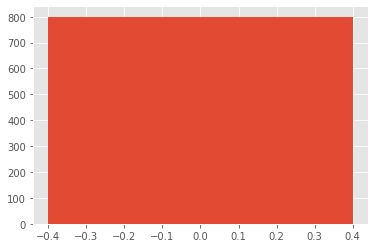

In [98]:
from matplotlib import pyplot as plt

counts = {}
for i in kaggle['Predict']:
    if i == '-1':
        if 0 in counts:
            counts[0] += 1
        else:
            counts[0] = 1
        continue

    num_author = len(i.split())
    if num_author in counts:
        counts[num_author] += 1
    else:
        counts[num_author] = 1

plt.bar(counts.keys(), counts.values())
plt.show()

## Test

In [135]:
sample = logits['paper'][1]
print(sample.max())
# print(sample.where(sample.max(),  0))
for i in range(num_class):
    if sample[i] == sample.max().item():
        print(i)


tensor(1., grad_fn=<MaxBackward1>)
100


In [290]:
test_list[0]

'3 89'

In [293]:
logits['paper'][test_mask][0][3]

tensor(0.0067, grad_fn=<SelectBackward0>)

In [205]:
for i in range(100):
    if logits['paper'][0][i] == logits['paper'][0].max():
        print(i)

53


In [41]:
mask = data['paper'].train_mask
~mask

tensor([ True,  True,  True,  ..., False, False, False])

In [104]:
pred_list[:5]

['-1', '-1', '-1', '41 53', '-1']

In [105]:
test_list[:5]

['3 89', '74 86', '47', '15', '64']

In [43]:
test_logits.max()

NameError: name 'test_logits' is not defined

In [42]:
logits[]

{'paper': tensor([[ 0.7373, -4.3554,  0.8266,  ...,  1.8072,  1.5695, -0.9569],
         [ 0.5528, -3.7845, -0.7132,  ...,  0.7833,  0.9154, -1.5261],
         [ 0.3928,  0.2018, -0.5519,  ...,  0.0327, -1.0929, -0.3226],
         ...,
         [-0.2499,  0.1750, -0.2671,  ..., -0.1124,  0.3376, -1.6740],
         [ 1.2607,  1.6286, -0.8348,  ...,  1.8028,  0.7335, -2.0001],
         [ 0.8718,  0.3729,  0.0826,  ...,  1.2577,  0.6941, -1.4276]],
        grad_fn=<AddBackward0>),
 'coauthor': tensor([[-0.0195, -1.9382, -0.2104,  ..., -0.0297,  0.1136, -0.7669],
         [ 0.0502, -0.0893, -0.3858,  ..., -0.4169,  0.1639,  0.4475],
         [ 1.2138, -0.5204, -0.7967,  ...,  0.0628, -0.8351, -0.8316],
         ...,
         [-0.1113, -0.0474, -0.0763,  ..., -0.4788,  0.1056,  0.2801],
         [ 0.1526, -0.0863,  0.5457,  ..., -0.3850,  0.3349,  0.2677],
         [-0.8975, -1.1972, -2.0797,  ..., -1.4725,  0.2720,  0.2842]],
        grad_fn=<AddBackward0>),
 'venue': tensor([[-0.3312, -0.

In [81]:
logits['paper'].max()

tensor(0.0119, grad_fn=<MaxBackward1>)